# Recurrent Neural Networks

## Theory

RNNs are used to solve problems with sequence of information.
- Time Series
- Sentences
- Audio
- Car Trajectories
- Music

A sequence is a vector of values where its index points to a specific time.

A recurrent neuron sends output back to itself, instead of depending only on new input. That is, a neuron at time T-1 outputs information that will fill another neuron at time T, and consecutivelly to neuron at T to neuron at T+1.

Neurons that receive outputs from the past, are called memory neurons or cells.

Entire layers of Recurrent Neurons can also be created. They are flexible in terms of inputs and outputs: 

- Sequence to Sequence: input a time series data and output a time series data shifted into the future by a specific period of time.

- Sequence to Vector: input a paragraph, i.e. a sequence of words, and output a sentiment value, i.e. a single value vector.

- Vector to Sequence: pass a vector as a first value of a sequence (fill other values with 0) and output is a sequence of values. 


## Manual creation of RNNs

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# CONSTANTS

In [3]:
num_inputs = 2

In [4]:
num_neurons = 3

In [5]:
# PLACEHOLDERS

In [6]:
x0 = tf.placeholder(tf.float32, [None, num_inputs])

In [7]:
x1 = tf.placeholder(tf.float32, [None, num_inputs])

In [8]:
# VARIABLES

In [9]:
Wx = tf.Variable(tf.random_normal(shape = [num_inputs, num_neurons]))

In [10]:
Wy = tf.Variable(tf.random_normal(shape = [num_neurons, num_neurons]))

In [11]:
b = tf.Variable(tf.zeros([1, num_neurons]))

In [12]:
# GRAPHS

In [13]:
y0 = tf.tanh(tf.matmul(x0, Wx) + b)

In [14]:
y1 = tf.tanh(tf.matmul(y0, Wy) + tf.matmul(x1, Wx) + b)

In [15]:
init = tf.global_variables_initializer()

In [16]:
# CREATE DATA

In [17]:
x0_batch = np.array([ [0, 1], [2, 3], [4,5] ])
x1_batch = np.array([ [100, 101], [102, 103], [104, 105]])

In [18]:
with tf.Session() as sess:
    sess.run(init)
    
    y0_output_vals, y1_output_vals = sess.run(
        [ y0, y1 ], 
        feed_dict = {
            x0: x0_batch, 
            x1: x1_batch
        }
    )

In [19]:
y0_output_vals

array([[ 0.72785348,  0.80552036,  0.68613899],
       [ 0.98292738,  0.99910301,  0.99120921],
       [ 0.99905902,  0.9999963 ,  0.99979061]], dtype=float32)

In [20]:
y1_output_vals

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)

## Vanishing Gradients

Backpropagation in deep networks vanishing gradients issue arise.

Vanishing gradients occur when gradients at layers near to the input, tend to be so small that weights never change. On the other hand, Exploding Gradients occur if gradients start to increase instead of decrease.

This problem is related to activation functions and the way they are computed: 

- Sigmoid activation: with high positive numbers the function tends to 1, and with very high negative numbers it tends to 0. In both cases the slope of the derivative tends to 0. Which leads to unchanging weights.

- Hyperbolic tangent has a similar problem

Different activation functions: 

- Rectified Linear Unit (ReLU): does not saturate positive values. However it is going to output always 0 for negative numbers.

- "Leaky" ReLU: similar to ReLU but with a small slope for negative numbers. 

- Exponential Linear Unit (ELU).

### Other solutions

- Batch normalization: Normalize batches by using their mean and std. 
- Gradient clipping: Cut gradients into some boundaries, like [-1, 1]



## Specialized neuron units for RNN

Solutions presented for Vanishing gradients can apply for RNN, but they could slow down training.

### LSTM

Long Short Term Memory. Introduces the concept of the Cell state. It consists of several phases: 

- Forget gates layer: decide which information will be taken / replaced from the cell state, thus, forgetting. 
$$ f_t = \sigma (W_f \cdot [h_{t-1}, x_t] + b_f) $$
Sigma function will output a number between 0 and 1, 1 meaning to keep the value and 0 forget it. 
- Decide which new information will be stored in the cell state:
  - input gate layer: $$ i_t = \sigma (W_i \cdot [h_{t-1}, x_t] + b_i) $$
  - new candidate values: $$ \tilde{C}_t = tanh(W_C \cdot [h_{t-1}, x_t] + b_C) $$

- Update the old cell state
$$ C_t = f_t * C_{t-1} + i_t * \tilde{C}_t $$

- Output decision. It is a version of cell state but filtered. 
$$ o_t = \sigma (W_o \cdot [h_{t-1}, x_t] + b_o) $$
$$ h_t = o_t * tanh(C_t) $$

### LSTM (with peepholes)

Allows sigma functions to see the current cell state, as follows: 

$$ f_t = \sigma (W_f \cdot [C_{t-1}, h_{t-1}, x_t] + b_f) $$
$$ i_t = \sigma (W_i \cdot [C_{t-1}, h_{t-1}, x_t] + b_i) $$
$$ o_t = \sigma (W_o \cdot [C_{t-1}, h_{t-1}, x_t] + b_o) $$


### GRU

Gated Recurrent Unit. It simplifies some of the LSTM steps, as follows: 

$$ z_t = \sigma(W_z \cdot [h_{t-1}, x_t]) $$
$$ r_t = \sigma(W_r \cdot [h_{t-1}, x_t]) $$
$$ \tilde{h}_t = tanh(W \cdot [r_t * h_{t-1}, x_t]) $$
$$ h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t $$


## RNN with TF API

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts = False):
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
        
        # Create Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1, steps, 1), \
                y_batch[:,1:].reshape(-1, steps, 1), \
                batch_ts
        else: 
            return y_batch[:,:-1].reshape(-1, steps, 1), \
                y_batch[:,1:].reshape(-1, steps, 1)

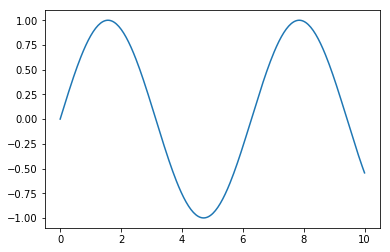

In [23]:
ts_data = TimeSeriesData(250, 0, 10)
plt.plot(ts_data.x_data, ts_data.y_true)

In [24]:
num_time_steps = 30

In [25]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, return_batch_ts=True)

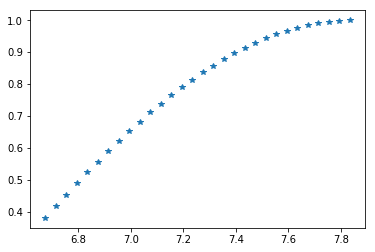

In [26]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

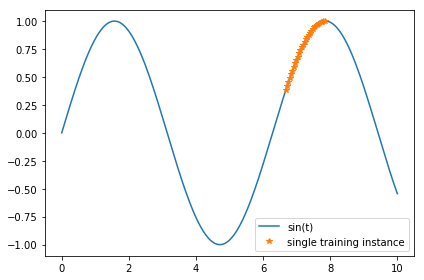

In [27]:
plt.plot(ts_data.x_data, ts_data.y_true, label='sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='single training instance')
plt.legend()
plt.tight_layout()

In [28]:
# TRAINING DATA

In [29]:
train_inst = np.linspace(
    5, 
    5 + ts_data.resolution * (num_time_steps + 1), 
    num_time_steps + 1
)

In [30]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

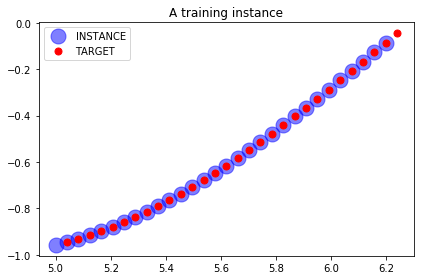

In [31]:
plt.title('A training instance')
plt.plot(
    train_inst[:-1], 
    ts_data.ret_true(train_inst[:-1]), 
    'bo', 
    markersize=15, 
    alpha=0.5, 
    label='INSTANCE'
)
plt.plot(
    train_inst[1:],
    ts_data.ret_true(train_inst[1:]),
    'ro', 
    markersize=7, 
    label = 'TARGET'
)
plt.legend()
plt.tight_layout()

### Creating the model

In [32]:
tf.reset_default_graph()

In [33]:
num_inputs = 1

In [34]:
num_neurons = 100

In [35]:
num_outputs = 1

In [36]:
learning_rate = 0.001

In [37]:
num_train_iterations = 2000

In [38]:
batch_size = 1

In [39]:
# Placeholders

In [40]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])

In [41]:
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [42]:
# RNN cell layer

In [43]:
basic_cell = tf.contrib.rnn.GRUCell(
    num_units = num_neurons, 
    activation = tf.nn.relu
)
cell = tf.contrib.rnn.OutputProjectionWrapper(
    cell = basic_cell, 
    output_size = num_outputs
)

In [44]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

In [45]:
# MSE
loss = tf.reduce_mean(tf.square(outputs - y))

In [46]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [47]:
train = optimizer.minimize(loss)

In [48]:
init = tf.global_variables_initializer()

In [49]:
# SESSION

In [50]:
# I'm not using GPU, but this is a useful command
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.85)

In [51]:
saver = tf.train.Saver()

In [52]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict = {X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE", mse)
            
    saver.save(sess, './rnn_time_series_model_davizuku')

0 	MSE 0.340114
100 	MSE 0.064391
200 	MSE 0.0458585
300 	MSE 0.0332636
400 	MSE 0.0108613
500 	MSE 0.00128034
600 	MSE 0.0133791
700 	MSE 0.0135203
800 	MSE 0.00228212
900 	MSE 0.00475097
1000 	MSE 0.00236827
1100 	MSE 0.000259898
1200 	MSE 0.00280342
1300 	MSE 0.00137792
1400 	MSE 9.36429e-05
1500 	MSE 0.000234335
1600 	MSE 0.00326221
1700 	MSE 0.000544061
1800 	MSE 7.97201e-05
1900 	MSE 4.39684e-06


In [53]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_time_series_model_davizuku')
    
    X_new = np.sin(
        np.array(
            train_inst[:-1].reshape(
                -1, 
                num_time_steps, 
                num_inputs
            )
        )
    )
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_davizuku


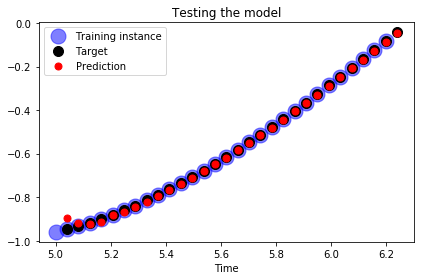

In [54]:
plt.title('Testing the model')
# Training instance
plt.plot(
    train_inst[:-1], 
    np.sin(train_inst[:-1]), 
    'bo', 
    markersize=15,
    alpha=0.5,
    label='Training instance'
)
# Target to predict (correct test values np.sin(train))
plt.plot(
    train_inst[1:], 
    np.sin(train_inst[1:]),
    'ko', 
    markersize=10, 
    label='Target'
)
# Model's prediction
plt.plot(
    train_inst[1:],
    y_pred[0,:, 0],
    'ro', 
    markersize=7,
    label='Prediction'
)
plt.xlabel('Time')
plt.legend()
plt.tight_layout()

### Generating a new sequence

In [56]:
len(ts_data.x_data)

250

In [57]:
num_time_steps

30

In [59]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_time_series_model_davizuku')
    
    # SEED ZEROS
    
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(
            1, 
            num_time_steps, 
            1
        )
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_davizuku


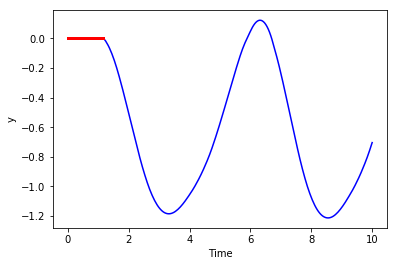

In [60]:
plt.plot(
    ts_data.x_data, 
    zero_seq_seed, 
    'b-'
)
plt.plot(
    ts_data.x_data[:num_time_steps], 
    zero_seq_seed[:num_time_steps], 
    'r', 
    linewidth = 3
)
plt.xlabel('Time')
plt.ylabel('y')

In [65]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_time_series_model_davizuku')
    
    # SEED ZEROS
    
    training_instance = list(ts_data.y_true[:30])
    
    
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(
            1, 
            num_time_steps, 
            1
        )
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_davizuku


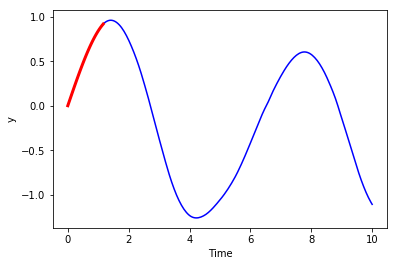

In [62]:
plt.plot(
    ts_data.x_data, 
    training_instance, 
    'b-'
)
plt.plot(
    ts_data.x_data[:num_time_steps], 
    training_instance[:num_time_steps], 
    'r', 
    linewidth = 3
)
plt.xlabel('Time')
plt.ylabel('y')

In [68]:
np.array(range(10))[-2:]

array([8, 9])

In [69]:
np.array(range(10))[:-2]

array([0, 1, 2, 3, 4, 5, 6, 7])

In [74]:
training_instance = list(ts_data.y_true[:30])
np.array(training_instance).shape

(30,)